<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215 entries, 57 to 1271
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   week_start_dt     1215 non-null   object 
 1   week_end_dt       1215 non-null   object 
 2   vietnam_season    1215 non-null   int64  
 3   p_color           1215 non-null   object 
 4   price             1215 non-null   float64
 5   total_volume      1215 non-null   float64
 6   brazil            1215 non-null   float64
 7   india             1215 non-null   float64
 8   vietnam           1215 non-null   float64
 9   indonesia         1215 non-null   float64
 10  china             1215 non-null   float64
 11  brazil_season     1215 non-null   bool   
 12  indonesia_season  1215 non-null   bool   
 13  india_season      1215 non-null   bool   
 14  china_season      1215 non-null   bool   
 15  jordan_max_price  1215 non-null   float64
 16  jordan_min_price  1215 non-null   float64

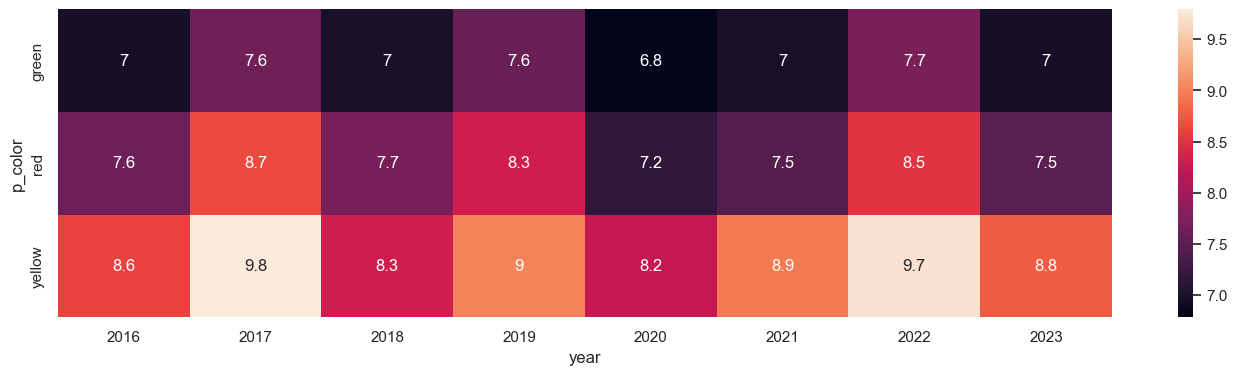

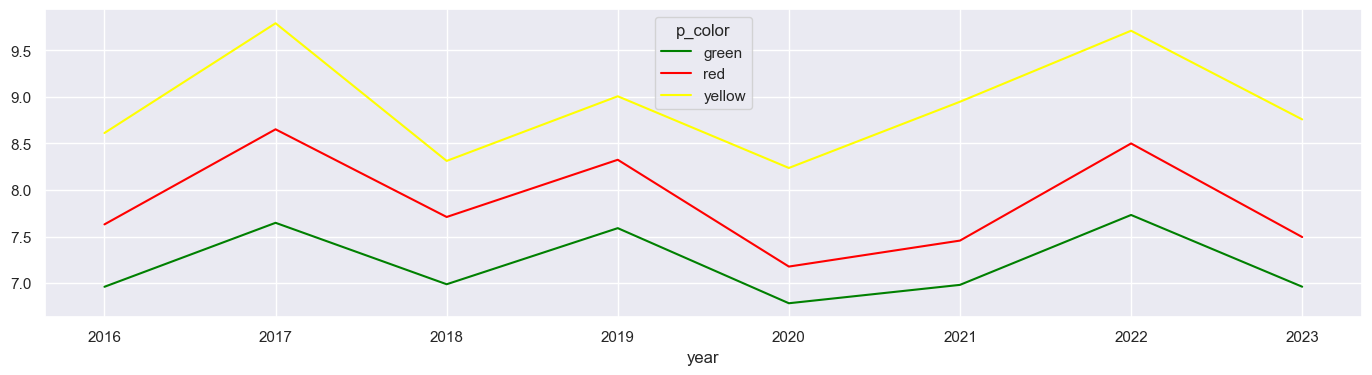

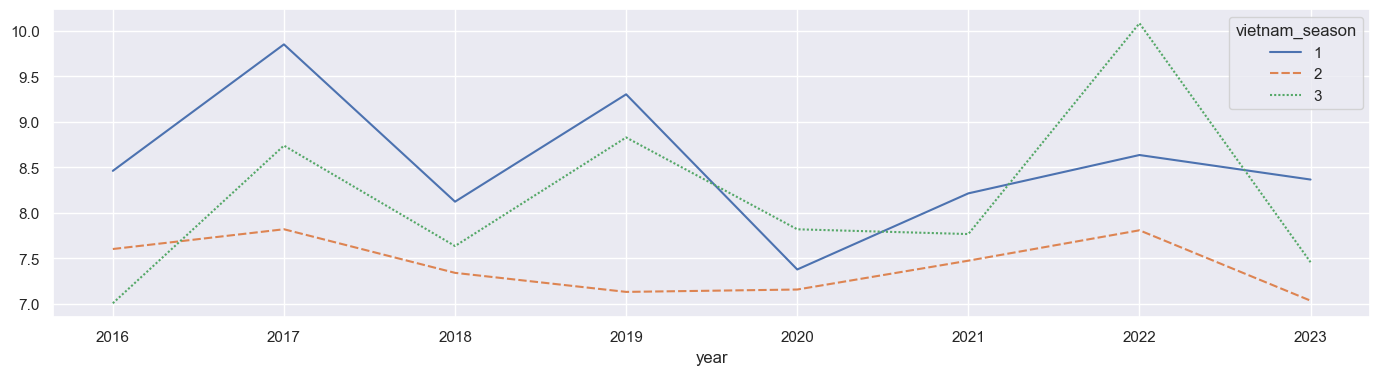

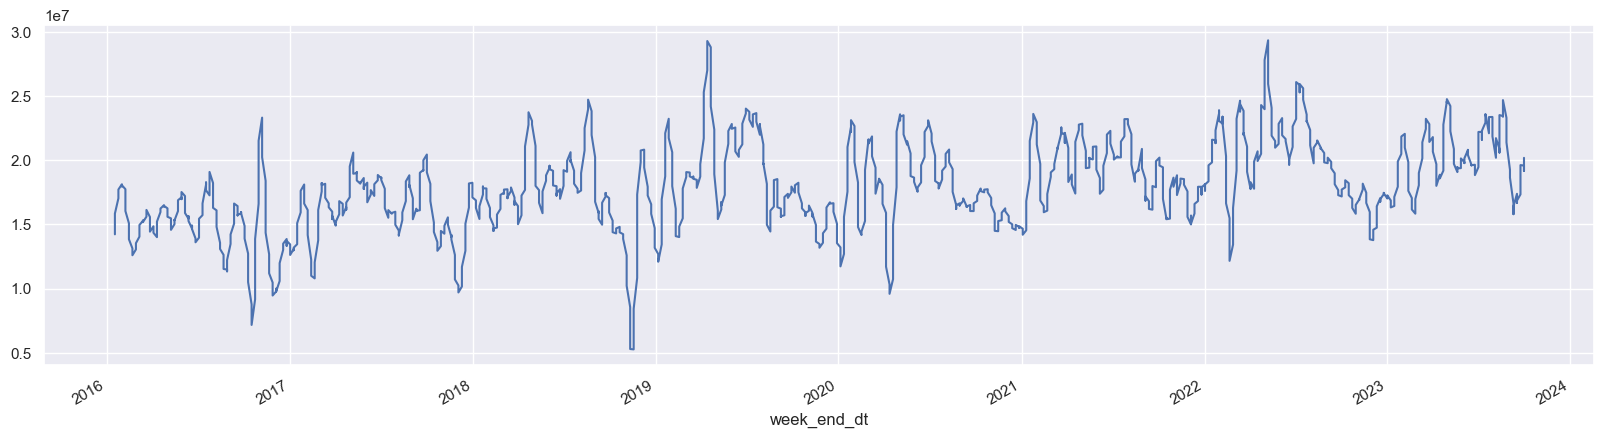

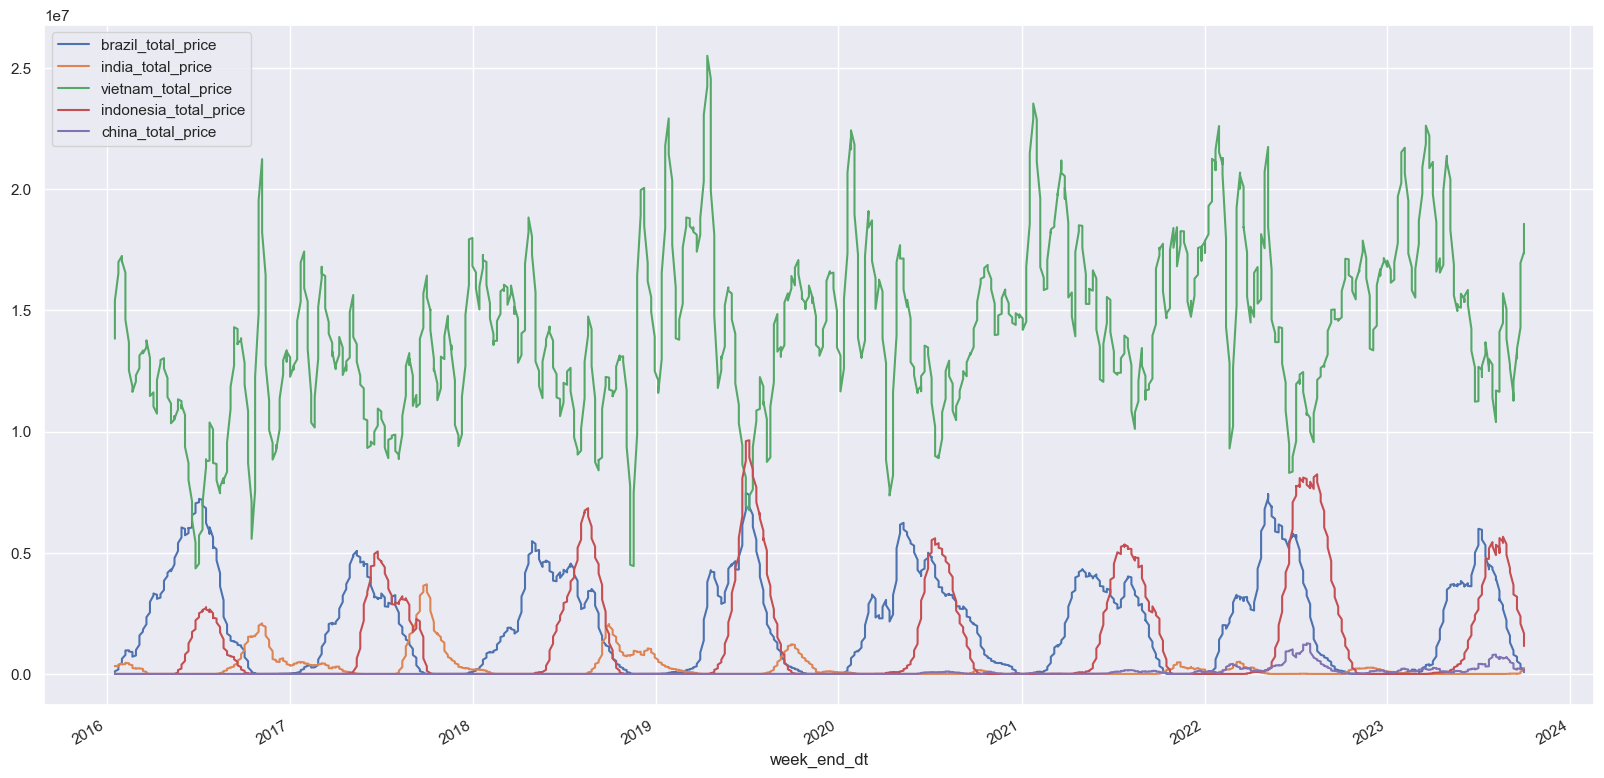

In [83]:
%run C:\Users\Omar\Desktop\Omar_Files\Python_Analysis\Siteck_ML\Pepper_Price_Analysis\notebooks\2_Features_Engineering_copy.ipynb

---
### *A.<BR> Importing needed libraries*

In [84]:
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,mean_absolute_error,accuracy_score,root_mean_squared_error
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import XGBRegressor,XGBRFRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import (TimeSeriesSplit,train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score,KFold)
from tqdm import tqdm

---
### *B.<BR> Data Scalling*

---
### *C.<BR> Quick Comparison between multiple models with the default parameters*

#### *C.1 <BR>Creating one function to use over the three datasets*

In [85]:
models = {
                "RandomForestRegressor": RandomForestRegressor(),
                "DecisionTreeRegressor": DecisionTreeRegressor(),
                #"LinearRegression": LinearRegression(),
                "XGBRFRegressor": XGBRFRegressor(),
                #"XGBRegressor":XGBRegressor(),
                "GradientBoostingRegressor":GradientBoostingRegressor(),
                "AdaBoostRegressor": AdaBoostRegressor(),
                "BaggingRegressor":BaggingRegressor()
                
                
            }

params={        
                "RandomForestRegressor":{
                    "n_estimators":[90,100,110], 
                    "min_samples_split":[2,4,6],
                    "min_samples_leaf":[0.8,1],
                    "bootstrap":[True, False],                                                                                                    
                    "max_features":["sqrt","log2","auto"],                                     
                    "max_depth":[2,3,4],
                    "criterion":['poisson', 'squared_error','friedman_mse','absolute_error']
                    },

                "DecisionTreeRegressor": {
                    'criterion':['poisson', 'squared_error','friedman_mse','absolute_error'],
                    'splitter': ['best', 'random'],
                    "max_depth":[2,3,4], 
                    "min_samples_split":[2,4,6],
                    "min_samples_leaf":[0.5,0.8],
                    #'max_features': [1,2,3,4],
                },
                #"LinearRegression":{ },

                "XGBRFRegressor":{
                    'learning_rate': [0.001,0.1,1],
                    'n_estimators': [90, 100, 110], 
                    "booster":["gbtree"],
                    'colsample_bytree': [0.5,0.8], 
                    'colsample_bynode': [0.5,0.8],
                    'random_state':[42]
                },

                
                "GradientBoostingRegressor":{
                    #'loss':['squared_error', 'huber', 'absolute_error', 'quantile'],
                    'learning_rate': [0.01,0.1,1],
                    'n_estimators': [90, 100, 110],
                    'subsample': [0.8,1],
                    #'criterion':['squared_error', 'friedman_mse'],
                    'min_samples_split': [2, 4, 6],
                    'min_samples_leaf': [0.8, 1],
                    'max_depth':[2,3,4],
                    #'max_features': ['sqrt', 'log2', 'auto']
                },
                "AdaBoostRegressor":{
                    'n_estimators': [45,50,55],
                    'learning_rate': [0.0001,0.001,0.01],
                    'loss':['linear','square','exponential'],
                    #'random_state':[42]
                    
                },
                "BaggingRegressor":{},
                
            }

In [87]:
scaler = StandardScaler()
for col in df_all:
    if col not in ['price','green', 'red', 'yellow']:
            df_all[col]=scaler.fit_transform(df_all[[col]])

In [115]:
def evaluate_models(data,models,params):
    tscv = TimeSeriesSplit(n_splits=4,max_train_size=16,test_size=4,gap=0)
    mae_scores = []
    y_pred_results=[]

    test_data=data[-20:]
    time_series_data = test_data.values            
    report = {}
    #report2={}
    for i in tqdm(range(len(list(models)))):
                        model=list(models.values())[i]
                        para=params[list(models.keys())[i]]
                        RandomSearchCV=RandomizedSearchCV(model,cv=3,param_distributions=para)

                        for train_index, test_index in tscv.split(time_series_data):
                                X_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
                                X_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]

                                RandomSearchCV.fit(X_train,y_train)

                                model.set_params(**RandomSearchCV.best_params_)
                                model.fit(X_train,y_train)

                                y_train_prediction=model.predict(X_train)
                                y_test_prediction=model.predict(X_test)

                                model_train_root_mean_squared_error=root_mean_squared_error(y_train,y_train_prediction)
                                model_train_mean_absolute_percentage_error=mean_absolute_percentage_error(y_train,y_train_prediction)
                                model_train_r2_score=r2_score(y_train,y_train_prediction)
                                

                        #report[list(models.keys())[i]] = model_train_mean_absolute_percentage_error
                        report[list(models.keys())[i]] = (model_train_root_mean_squared_error,model_train_mean_absolute_percentage_error,model_train_r2_score,
                                                            RandomSearchCV.best_params_)


    return report

In [91]:
model_report:dict=evaluate_models(data=df_all,models=models,params=params)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:42<00:00,  7.13s/it]


In [92]:
model_report

{'RandomForestRegressor': (np.float64(0.17496137887097044),
  np.float64(8.403053646130143),
  0.9371100326165207,
  0.0,
  {'n_estimators': 90,
   'min_samples_split': 2,
   'min_samples_leaf': 1,
   'max_features': 'log2',
   'max_depth': 2,
   'criterion': 'friedman_mse',
   'bootstrap': False}),
 'DecisionTreeRegressor': (np.float64(0.6976723444065328),
  np.float64(8.422652502604166),
  0.0,
  0.0,
  {'splitter': 'random',
   'min_samples_split': 2,
   'min_samples_leaf': 0.5,
   'max_depth': 3,
   'criterion': 'poisson'}),
 'XGBRFRegressor': (np.float64(0.07906050722857705),
  np.float64(7.7207926476888735),
  0.9871584875638244,
  0.0,
  {'random_state': 42,
   'n_estimators': 90,
   'learning_rate': 1,
   'colsample_bytree': 0.8,
   'colsample_bynode': 0.8,
   'booster': 'gbtree'}),
 'GradientBoostingRegressor': (np.float64(0.0),
  np.float64(7.638883276113767),
  1.0,
  0.0,
  {'subsample': 1,
   'n_estimators': 110,
   'min_samples_split': 2,
   'min_samples_leaf': 1,
   'max

In [93]:
model_report_df=pd.DataFrame(model_report).iloc[:-1] 

In [94]:
model_report_df

,RandomForestRegressor,DecisionTreeRegressor,XGBRFRegressor,GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor
0,0.174961,0.697672,0.079061,0.0,0.029831,0.171108
1,8.403054,8.422653,7.720793,7.638883,8.526712,8.364726
2,0.93711,0.0,0.987158,1.0,0.998172,0.93985
3,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
model_report_df["metrices"]=["model_train_root_mean_squared_error","model_train_mean_absolute_percentage_error","model_train_r2_score"]

In [96]:
model_report_df

,RandomForestRegressor,DecisionTreeRegressor,XGBRFRegressor,GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor,metrices
0,0.174961,0.697672,0.079061,0.0,0.029831,0.171108,model_train_root_mean_squared_error
1,8.403054,8.422653,7.720793,7.638883,8.526712,8.364726,model_test_root_mean_squared_error
2,0.93711,0.0,0.987158,1.0,0.998172,0.93985,model_train_r2_score
3,0.0,0.0,0.0,0.0,0.0,0.0,model_test_r2_score


In [101]:
def evaluate_best_models():
    tscv = TimeSeriesSplit(n_splits=4,max_train_size=16,test_size=4,gap=0)
    mae_scores = []
    y_pred_results=[]

    test_data=df_all[-20:]
    time_series_data = test_data.values            
    for train_index, test_index in tscv.split(time_series_data):
        X_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
        X_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]

        model=GradientBoostingRegressor(learning_rate= 1,
                                        n_estimators= 1100,
                                        min_samples_split= 2,
                                        min_samples_leaf=1,
                                        max_depth=4,
                                        subsample= 1)
        
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        y_pred_results.append(y_pred)
        mae = np.mean(mean_absolute_error(y_test, y_pred))
        mae_scores.append(mae)
        #print(np.mean(mae_scores ))
        #print("----------------------------------" )

        outcome=pd.DataFrame(y_pred_results)

        outcome=pd.DataFrame(pd.DataFrame(outcome[0:4]).stack().reset_index(drop=True))
        new_date_index=pd.date_range(start="2023-07-16",end="2023-10-29",freq="W")
        new_date_index=pd.DataFrame({"date":new_date_index})
        outcome_red_XGBRFRegressor_all=pd.concat([outcome,new_date_index],axis=1).set_index("date")

    fig, ax = plt.subplots(figsize = (20,5));
    y_min = 6.5
    y_max = 9.5
    #sns.lineplot(df_red_outcomes[0]["XGBRFRegressor_boo"],color="blue");
    sns.lineplot(outcome_red_XGBRFRegressor_all,color="red");
    sns.lineplot(df_all['price'][-15:-4],color="black");      
    plt.legend(["best","actual"])       
    ax.vlines(x=["2023-07-16","2023-08-13","2023-09-10","2023-10-01"],ymax=y_max,ymin=y_min)  
    fig.show()    

    return outcome_red_XGBRFRegressor_all



,0
date,
2023-07-16,9.180680
2023-07-23,9.180680
2023-07-30,9.180680
2023-08-06,9.180680
2023-08-13,8.587895
2023-08-20,8.587895
2023-08-27,8.587895
2023-09-03,8.587895
2023-09-10,7.644073


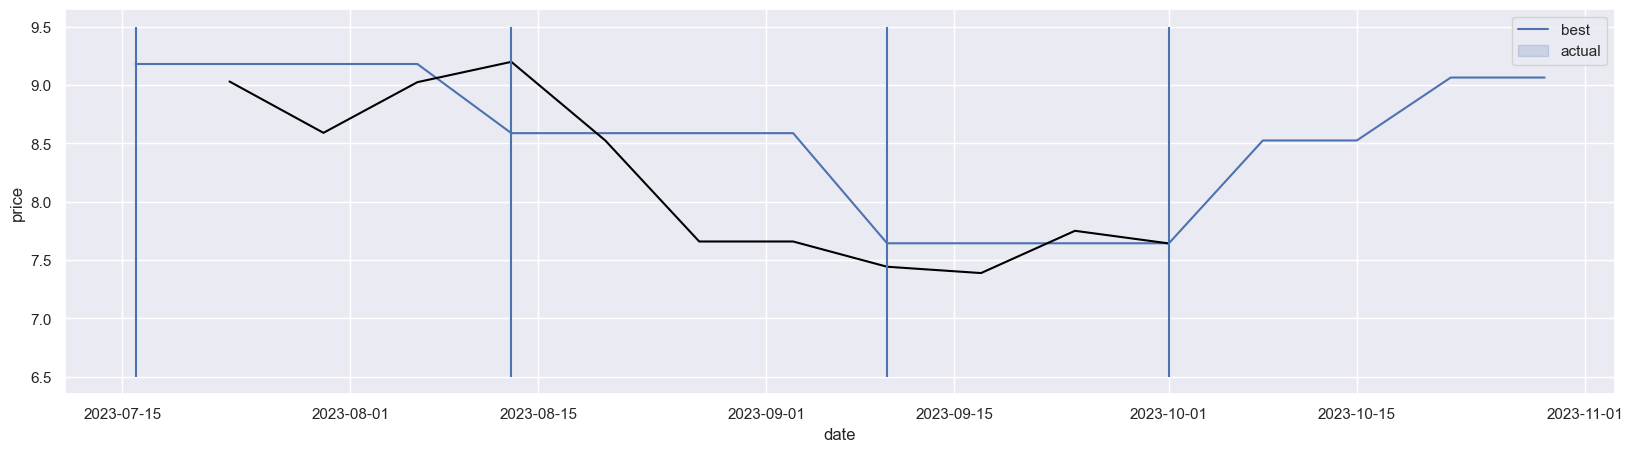

In [102]:
evaluate_best_models()

In [141]:
def experments():
    for test in range(2):
        model_report:dict=evaluate_models(data=df_all,models=models,params=params)
        model_report_df=pd.DataFrame(model_report).iloc[:-1] 
        model_report_df["metrices"]=["model_train_root_mean_squared_error","model_train_mean_absolute_percentage_error","model_train_r2_score"]
        model_report_df.to_csv(r"C:\Users\Omar\Desktop\Omar_Files\Python_Analysis\Siteck_ML\Pepper_Price_Analysis\Experiments_Tracking\Experments_results.txt", index=False)
experments()

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:47<00:00,  7.99s/it]


---